In [1]:
import xtrack as xt
import xobjects as xo
import xcoll as xc
import xpart as xp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
line = xt.Line.from_json('../injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

#Set cavitiy voltages correctly
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180

line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180

#Add displacment of vertical dogleg in LSS5
line['qd.51710']._shift_y = -5.273e-3
line['qfa.51810']._shift_y = -17.369e-3
line['qd.51910']._shift_y = -5.273e-3

tab = line.get_table()
mask = [el.startswith('Limit') for el in tab.element_type]

for name in tab.name[mask]:
    if 'qd.51710' in name:
        line[name]._shift_y = -5.273e-3
    elif 'qfa.51810' in name:
        line[name]._shift_y = -17.369e-3
    elif 'qd.51910' in name:
        line[name]._shift_y = -5.273e-3
tw = line.twiss()

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           


In [36]:
particle_on_co = tw.particle_on_co.copy()
particle_ref = line.particle_ref.copy()
R_matrix = tw.R_matrix.copy()
tw2 = line.twiss(particle_on_co=particle_on_co,
                                    particle_ref=particle_ref,
                                    R_matrix=R_matrix)

In [46]:
from xtrack.twiss import find_closed_orbit_line

In [47]:
particle_on_co2 = find_closed_orbit_line(line)

In [2]:
num_turns = 1000
num_particles = 1000

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [14]:
#Check aperture
df_with_coll = line.check_aperture()

#OPtimize line and optics
# line.build_tracker()
# tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
line.optimize_for_tracking()

Checking aperture:   0%|          | 0/30210 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Disable xdeps expressions
Replace slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data


In [15]:
#x and y on closed orbit
part = line.build_particles(
    x_norm = np.zeros(num_particles),
    y_norm = np.zeros(num_particles),
    px_norm = np.zeros(num_particles),
    py_norm = np.zeros(num_particles),
    zeta= np.zeros(num_particles),
    delta = np.linspace(-5e-3, 5e-3, num_particles),
    nemitt_x=3.5e-6, nemitt_y=3.5e-6
)
#variations for close to bottleneck
# x_sigma = 12
# y_sigma = 5.5
# angle = 0 #np.pi/4, np.pi/2, np.pi*3/4, np.pi, np.pi*5/4, np.pi*3/2, np.pi*7/4

# part = xt.Particles(
#     x_norm = np.ones(num_particles)*x_sigma*np.cos(angle),
#     y_norm = np.ones(num_particles)*y_sigma*np.cos(angle),
#     px_norm = np.ones(num_particles)*x_sigma*np.sin(angle),
#     py_norm = np.ones(num_particles)*y_sigma*np.sin(angle),
#     zeta= np.zeros(num_particles),
#     delta = np.linspace(-5e-3, 5e-3, num_particles),
# )

In [7]:
tw = line.twiss()



Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




ClosedOrbitSearchError: 

In [11]:
len(line.element_names)

30212

In [16]:
line_no_opt = xt.Line.from_json('../injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

#Set cavitiy voltages correctly
line_no_opt['acl.31735'].frequency = 800e6
line_no_opt['acl.31735'].voltage = 2 * 0.18e6
line_no_opt['acl.31735'].lag = 180

line_no_opt['actcse.31632'].frequency = 200e6
line_no_opt['actcse.31632'].voltage = 4.5e6
line_no_opt['actcse.31632'].lag = 180

#Add displacment of vertical dogleg in LSS5
line_no_opt['qd.51710'].shift_y = -5.273e-3
line_no_opt['qfa.51810'].shift_y = -17.369e-3
line_no_opt['qd.51910'].shift_y = -5.273e-3

tab = line_no_opt.get_table()
mask = [el.startswith('Limit') for el in tab.element_type]

for name in tab.name[mask]:
    if 'qd.51710' in name:
        line_no_opt[name].shift_y = -5.273e-3
    elif 'qfa.51810' in name:
        line_no_opt[name].shift_y = -17.369e-3
    elif 'qd.51910' in name:
        line_no_opt[name].shift_y = -5.273e-3

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           


In [17]:
tw = line_no_opt.twiss()

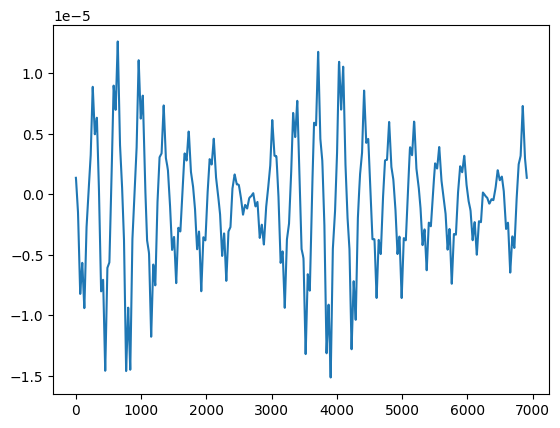

In [22]:
plt.figure()
plt.plot(tw.s, tw.x)

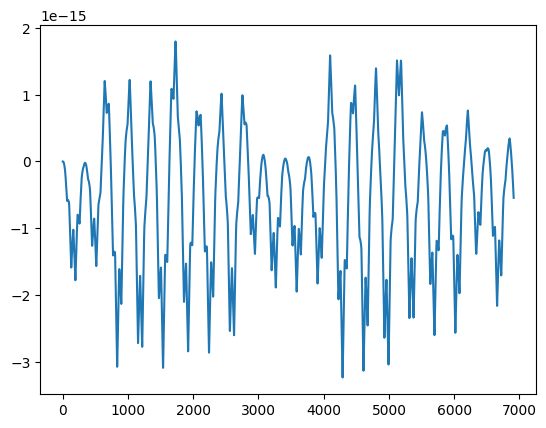

In [23]:
plt.figure()
plt.plot(tw2.s, tw2.x)

In [19]:
line_opt = xt.Line.from_json('../injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

#Set cavitiy voltages correctly
line_opt['acl.31735'].frequency = 800e6
line_opt['acl.31735'].voltage = 2 * 0.18e6
line_opt['acl.31735'].lag = 180

line_opt['actcse.31632'].frequency = 200e6
line_opt['actcse.31632'].voltage = 4.5e6
line_opt['actcse.31632'].lag = 180

#Add displacment of vertical dogleg in LSS5
line_no_opt['qd.51710'].shift_y = -5.273e-3
line_no_opt['qfa.51810'].shift_y = -17.369e-3
line_no_opt['qd.51910'].shift_y = -5.273e-3

tab = line_no_opt.get_table()
mask = [el.startswith('Limit') for el in tab.element_type]

for name in tab.name[mask]:
    if 'qd.51710' in name:
        line_no_opt[name].shift_y = -5.273e-3
    elif 'qfa.51810' in name:
        line_no_opt[name].shift_y = -17.369e-3
    elif 'qd.51910' in name:
        line_no_opt[name].shift_y = -5.273e-3

tw1 = line_opt.twiss()
line_opt.optimize_for_tracking()
#tw2 = line_opt.twiss()

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           
Disable xdeps expressions
Replace slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data


In [20]:
tw2 = line_opt.twiss()

In [82]:
from xtrack.twiss import find_closed_orbit_line

In [83]:
part_on_co_opt = find_closed_orbit_line(line_opt)



Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




ClosedOrbitSearchError: 

In [79]:
line_no_opt.particle_on_co

AttributeError: 'Line' object has no attribute 'particle_on_co'

In [70]:
line_opt.particle_ref.y

array([0.])

In [66]:
line_opt.particle_ref.start_tracking_at_element=np.int64(0)

In [52]:
opt_names = line_opt.element_names
no_opt_names = line_no_opt.element_names
rem_names = {}
prev = no_opt_names[0]
for name in no_opt_names[1:]:
    if 'qd.51710' in name or 'qfa.51810' in name or 'qd.51910' in name:
        if name not in opt_names:
            rem_names[name] = line_no_opt[name]
            idx = line_opt.element_names.index(prev)
            line_opt.insert_element(name=name, element=line_no_opt[name], at=idx+1)
    prev = name

In [53]:
l2 = []
for name in line_opt.element_names:
    if 'qd.51710' in name or 'qfa.51810' in name or 'qd.51910' in name:
        print(name)
        l2.append(name)

qd.51710_entry_aper_upstream
qd.51710_entry
qd.51710_entry_aper_downstream
drift_qd.51710..0
qd.51710..0_aper_upstream
qd.51710..0
qd.51710..0_aper_downstream
drift_qd.51710..1
qd.51710..1_aper_upstream
qd.51710..1
qd.51710..1_aper_downstream
drift_qd.51710..2
qd.51710..2_aper_upstream
qd.51710..2
qd.51710..2_aper_downstream
drift_qd.51710..3
qd.51710..3_aper_upstream
qd.51710..3
qd.51710..3_aper_downstream
drift_qd.51710..4
qd.51710..4_aper_upstream
qd.51710..4
qd.51710..4_aper_downstream
drift_qd.51710..5
qd.51710..5_aper_upstream
qd.51710..5
qd.51710..5_aper_downstream
drift_qd.51710..6
qd.51710..6_aper_upstream
qd.51710..6
qd.51710..6_aper_downstream
drift_qd.51710..7
qd.51710..7_aper_upstream
qd.51710..7
qd.51710..7_aper_downstream
drift_qd.51710..8
qd.51710_exit_aper_upstream
qd.51710_exit
qd.51710_exit_aper_downstream
qfa.51810_aper_upstream
qfa.51810
qfa.51810_aper_downstream
qd.51910_entry_aper_upstream
qd.51910_entry
qd.51910_entry_aper_downstream
drift_qd.51910..0
qd.51910..

In [54]:
l1 = []
for name in no_opt_names:
    if 'qd.51710' in name or 'qfa.51810' in name or 'qd.51910' in name:
        print(name)
        l1.append(name)

qd.51710_entry_aper_upstream
qd.51710_entry
qd.51710_entry_aper_downstream
drift_qd.51710..0
qd.51710..0_aper_upstream
qd.51710..0
qd.51710..0_aper_downstream
drift_qd.51710..1
qd.51710..1_aper_upstream
qd.51710..1
qd.51710..1_aper_downstream
drift_qd.51710..2
qd.51710..2_aper_upstream
qd.51710..2
qd.51710..2_aper_downstream
drift_qd.51710..3
qd.51710..3_aper_upstream
qd.51710..3
qd.51710..3_aper_downstream
drift_qd.51710..4
qd.51710..4_aper_upstream
qd.51710..4
qd.51710..4_aper_downstream
drift_qd.51710..5
qd.51710..5_aper_upstream
qd.51710..5
qd.51710..5_aper_downstream
drift_qd.51710..6
qd.51710..6_aper_upstream
qd.51710..6
qd.51710..6_aper_downstream
drift_qd.51710..7
qd.51710..7_aper_upstream
qd.51710..7
qd.51710..7_aper_downstream
drift_qd.51710..8
qd.51710_exit_aper_upstream
qd.51710_exit
qd.51710_exit_aper_downstream
qfa.51810_aper_upstream
qfa.51810
qfa.51810_aper_downstream
qd.51910_entry_aper_upstream
qd.51910_entry
qd.51910_entry_aper_downstream
drift_qd.51910..0
qd.51910..

In [15]:
for name in no_opt_names:
    if 'qd.51710' in name or 'qfa.51810' in name or 'qd.51910' in name:
        print(name)

qd.51710_entry_aper_upstream
qd.51710_entry
qd.51710_entry_aper_downstream
drift_qd.51710..0
qd.51710..0_aper_upstream
qd.51710..0
qd.51710..0_aper_downstream
drift_qd.51710..1
qd.51710..1_aper_upstream
qd.51710..1
qd.51710..1_aper_downstream
drift_qd.51710..2
qd.51710..2_aper_upstream
qd.51710..2
qd.51710..2_aper_downstream
drift_qd.51710..3
qd.51710..3_aper_upstream
qd.51710..3
qd.51710..3_aper_downstream
drift_qd.51710..4
qd.51710..4_aper_upstream
qd.51710..4
qd.51710..4_aper_downstream
drift_qd.51710..5
qd.51710..5_aper_upstream
qd.51710..5
qd.51710..5_aper_downstream
drift_qd.51710..6
qd.51710..6_aper_upstream
qd.51710..6
qd.51710..6_aper_downstream
drift_qd.51710..7
qd.51710..7_aper_upstream
qd.51710..7
qd.51710..7_aper_downstream
drift_qd.51710..8
qd.51710_exit_aper_upstream
qd.51710_exit
qd.51710_exit_aper_downstream
qfa.51810_aper_upstream
qfa.51810
qfa.51810_aper_downstream
qd.51910_entry_aper_upstream
qd.51910_entry
qd.51910_entry_aper_downstream
drift_qd.51910..0
qd.51910..

In [56]:
line_opt.twiss()



Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




ClosedOrbitSearchError: 